# Regression LSTM with best parameters
    find the best prediction window to apply w/ lr = 0.0001

# Import libraries

In [21]:
!pip install pandas
!pip install sklearn
!pip install matplotlib

import pandas as pd;
import numpy as np;
import sklearn
import matplotlib.pyplot as plt
import time

date =  [2018010000, 
         2018030000, 
         2018050000,
         2018070000, 
         2018090000, 
         2018110000]

# parameters
steps = 96
n_hidden = 2
units = 180
batch_size = 336
epochs = 180
features_num = 14

# lists to append results
mae_gen = []
mae_nor = []
mae_spi = []
rmse_gen = []
rmse_nor = []
rmse_spi = []
y_pred_list = []
time_count = []

# Import keras libraries, packages and data:

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras import initializers
from keras import optimizers

# import data
data_full = pd.read_csv('Data_set_1_smaller_(1).csv', index_col = 0)

# Create loop for different dates:

In [26]:
# function to split data into correct shape for RNN
def split_data(X, y, steps):
    X_, y_ = list(), list()
    for i in range(steps, len(y)):
        X_.append(X[i - steps : i, :])
        y_.append(y[i]) 
    return np.array(X_), np.array(y_)

# function to cut data set so it can be divisible by the batch_size
def cut_data(data, batch_size):
     # see if it is divisivel
    condition = data.shape[0] % batch_size
    if condition == 0:
        return data
    else:
        return data[: -condition]

# design the LSTM
def regressor_tunning(kernel_initializer = 'he_uniform',
                      bias_initializer = initializers.Ones()):
    model = Sequential()
    if n_hidden == 1:
        model.add(LSTM(units = units,                    
                       batch_input_shape = (batch_size, steps, features_num), 
                       stateful = True,
                       kernel_initializer = kernel_initializer,
                       bias_initializer = bias_initializer))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(0.2))
    else:
        model.add(LSTM(units = units,                    
                       batch_input_shape = (batch_size, steps, features_num), 
                       stateful = True,
                       return_sequences = True,
                       kernel_initializer = kernel_initializer,
                       bias_initializer = bias_initializer))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(0.2))
        model.add(LSTM(units = units, 
                       batch_input_shape = (batch_size, steps, features_num), 
                       stateful = True,
                       kernel_initializer = kernel_initializer,
                       bias_initializer = bias_initializer))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    optimizer = optimizers.RMSprop()
    model.compile(loss = 'mse', metrics = ['mse', 'mae'], optimizer = optimizer)
    return model

# for final one
date = [2018110000]
  
# LOOP STARTS
for i in date:
    start_time = time.time()
    # data
    data = data_full.loc[data_full.index > i, :]

    # reset index
    data.reset_index(inplace = True)
    data.drop('index', axis = 1, inplace = True)

    # fill nan values in the whole data set
    data.fillna(data.mean(), inplace = True)

    from sklearn.model_selection import train_test_split

    # divide data into train and test 
    data_train, data_test = train_test_split(
             data, test_size = 0.15, shuffle=False)  
    
    from sklearn.preprocessing import MinMaxScaler

    # data scaling  (including offer (y))
    sc_X = MinMaxScaler()
    data_train = sc_X.fit_transform(data_train)
    data_test = sc_X.transform(data_test)
    
    # divide features and labels
    X_train = data_train[:, 0:14] 
    y_train = data_train[:, -1]
    X_test = data_test[:, 0:14] 
    y_test = data_test[:, -1] 

    # divide data into train and test 
    X_train, X_val, y_train, y_val = train_test_split(
             X_train, y_train, test_size = 0.10, shuffle=False)

    # put data into correct shape
    X_train, y_train = split_data(X_train, y_train, steps)
    X_test, y_test = split_data(X_test, y_test, steps)
    X_val, y_val = split_data(X_val, y_val, steps)

    X_train = cut_data(X_train, batch_size)
    y_train = cut_data(y_train, batch_size)
    X_test = cut_data(X_test, batch_size)
    y_test = cut_data(y_test, batch_size)
    X_val = cut_data(X_val, batch_size)
    y_val = cut_data(y_val, batch_size)

    model = regressor_tunning()
    
    # fitting the LSTM to the training set
    history = model.fit(X_train,
                        y_train, 
                        batch_size = batch_size, 
                        epochs = epochs,
                        shuffle = False)
                        #validation_data = (X_val, y_val))
    
    model.reset_states()
    
    # make new predicitons with test set
    y_pred = model.predict(X_test, batch_size = batch_size)
    
    # prices col = 15 (inverso should not be used as scalling was made with the whole data set)
    y_pred = (y_pred * sc_X.data_range_[14]) + (sc_X.data_min_[14])
    y_test = (y_test * sc_X.data_range_[14]) + (sc_X.data_min_[14])

    # smal adjustment
    y_test = pd.Series(y_test)
    y_test.replace(0, 0.0001,inplace = True)
    
    y_pred_list.append(y_pred)
    
    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae

    rmse_error = mse(y_test, y_pred, squared = False)
    mae_error = mae(y_test, y_pred)
    
    rmse_gen.append(rmse_error)
    mae_gen.append(mae_error)
    
    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================
    
    # Need to process data with spike occurences the same way as features
    data = pd.read_csv('Spike_binary_1std.csv', index_col = 0)

    # set predictive window according with tuning best results
    data = data.loc[data.index > i, :]

    # make sure shaded area will correspond to values outputed by LSTM
    data.reset_index(drop = True, inplace = True)

    # fill_nan is already made - so lets split data into test and train
    from sklearn.model_selection import train_test_split

    # divide data into train and test 
    shade_train, shade_test = train_test_split(
             data, test_size = 0.15, shuffle = False)

    # reset index of testing data
    shade_test.reset_index(drop = True, inplace = True)

    # function to split data into correct shape for RNN
    def split_data_shade(shade_test, steps):
        y_spike_occ = list()
        upper_lim = list()
        lower_lim = list()
        for i in range(steps, len(shade_test.index)):
            y_spike_occ.append(shade_test['spike_occurance'][i])
            upper_lim.append(shade_test['spike_upperlim'][i])
            lower_lim.append(shade_test['spike_lowerlim'][i])
        return np.array(y_spike_occ), np.array(upper_lim), np.array(lower_lim)

    # function to cut data set so it can be divisible by the batch_size
    def cut_data_shade(data, batch_size):
         # see if it is divisivel
        condition = data.shape[0] % batch_size
        if condition == 0:
            return data
        else:
            return data[: -condition]
    
    # shape y_spike_occ for the right size to compare results in normal and spike regions
    y_spike_occ, spike_upperlim, spike_lowerlim = split_data_shade(shade_test, steps)
    y_spike_occ = cut_data_shade(y_spike_occ, batch_size)

    # continue
    
    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]
    
    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mae_spike = mae(y_test_spike, y_pred_spike)
    
    rmse_spi.append(rmse_spike)
    mae_spi.append(mae_spike)
    
    # =============================================================================
    # Metric evaluation on normal regions
    # =============================================================================
    
    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)
    
    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 
    
    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]
    
    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mae_normal = mae(y_test_normal, y_pred_normal)
    
    rmse_nor.append(rmse_normal)
    mae_nor.append(mae_normal)
    
    elapsed_time = time.time() - start_time

    time_count.append(elapsed_time)

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\maria\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Epoch 1/180
6/6 [==============================] - 7s 1s/step - loss: 2.4735 - mse: 2.4735 - mae: 1.0016
Epoch 2/180
6/6 [==============================] - 7s 1s/step - loss: 0.1582 - mse: 0.1582 - mae: 0.3157
Epoch 3/180
6/6 [==============================] - 8s 1s/step - loss: 0.1669 - mse: 0.1669 - mae: 0.3315
Epoch 4/180
6/6 [==============================] - 11s 2s/step - loss: 0.2363 - mse: 0.2363 - mae: 0.3933
Epoch 5/180
6/6 [==============================] - 10s 2s/step - loss: 0.1848 - mse: 0.1848 - mae: 0.3436
Epoch 6/180
6/6 [==============================] - 11s 2s/step - loss: 0.1875 - mse: 0.1875 - mae: 0.3500
Epoch 7/180
6/6 [==============================] - 11s 2s/step - loss: 0.2222 - mse: 0.2222 - mae: 0.3843
Epoch 8/180
6/6 [==============================] - 10s 2s/step - loss: 0.1525 - mse: 0.1525 - mae: 0.3156
Epoch 9/180
6/6 [==============================] - 10s 2s/step - loss: 0.1917 - mse: 0.1917 - mae: 0.3595
Epoch 10/180
6/6 [==============================]

6/6 [==============================] - 10s 2s/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0280
Epoch 78/180
6/6 [==============================] - 10s 2s/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0273
Epoch 79/180
6/6 [==============================] - 10s 2s/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0263
Epoch 80/180
6/6 [==============================] - 10s 2s/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0270
Epoch 81/180
6/6 [==============================] - 9s 2s/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0253
Epoch 82/180
6/6 [==============================] - 9s 1s/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0253
Epoch 83/180
6/6 [==============================] - 9s 2s/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0250
Epoch 84/180
6/6 [==============================] - 10s 2s/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0246
Epoch 85/180
6/6 [==============================] - 9s 2s/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0243
Epoch 86/180
6/6 [==============================] - 9s

6/6 [==============================] - 10s 2s/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0168
Epoch 154/180
6/6 [==============================] - 10s 2s/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0179
Epoch 155/180
6/6 [==============================] - 11s 2s/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0167
Epoch 156/180
6/6 [==============================] - 9s 2s/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0179
Epoch 157/180
6/6 [==============================] - 9s 1s/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0168
Epoch 158/180
6/6 [==============================] - 9s 1s/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0176
Epoch 159/180
6/6 [==============================] - 9s 1s/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0172
Epoch 160/180
6/6 [==============================] - 9s 2s/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0171
Epoch 161/180
6/6 [==============================] - 10s 2s/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0174
Epoch 162/180
6/6 [============================

In [31]:
results = pd.DataFrame({                        
                        'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor,
    
                        'time': time_count})

#y_pred = pd.DataFrame({'dates': date,
#                       'Predicitons': y_pred_list})

#y_pred.to_csv('Pedictions_LSTM_5_prediction_window.csv')
results.to_csv('Results_LSTM_Prediction_window.csv')
results

rmse_general  mae_general  rmse_spike  mae_spike  rmse_normal  mae_normal  \
0     59.206006    32.266572   75.095039  40.107748    55.613483   30.750850   
1     36.356530    19.491790   56.834863  28.629130    30.859672   17.722749   
2     27.214883    17.259150   30.628762  21.652058    26.625771   16.553554   
3     28.155884    16.697367   32.377130  21.613011    27.451361   15.943710   
4     29.814576    18.606296   40.733153  24.234102    27.745150   17.736017   
5     29.355440    22.055076   41.345949  31.517682    26.099331   20.039576   

           time  
0  11222.361281  
1   8934.704042  
2   8004.332963  
3   9490.615029  
4   6434.632526  
5   2193.240561

In [28]:
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

results.style.apply(highlight_min)

In [24]:
results

rmse_general  mae_general  rmse_spike  mae_spike  rmse_normal  mae_normal  \
0     36.753872    24.360023   49.547439  31.386293    33.725673   23.001824   
1     38.962476    19.308989   61.775859  30.429582    32.758714   17.155980   
2     27.244339    17.124567   33.328991  22.994592    26.135302   16.181714   
3     28.740984    18.119340   32.508364  22.292849    28.118785   17.479466   
4     34.610033    30.461997   40.246530  35.016924    33.654237   29.757627   

          time  
0  4877.699733  
1  3691.841471  
2  3212.422024  
3  2486.948337  
4  2265.764607

In [29]:
!pip install matplotlib

import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


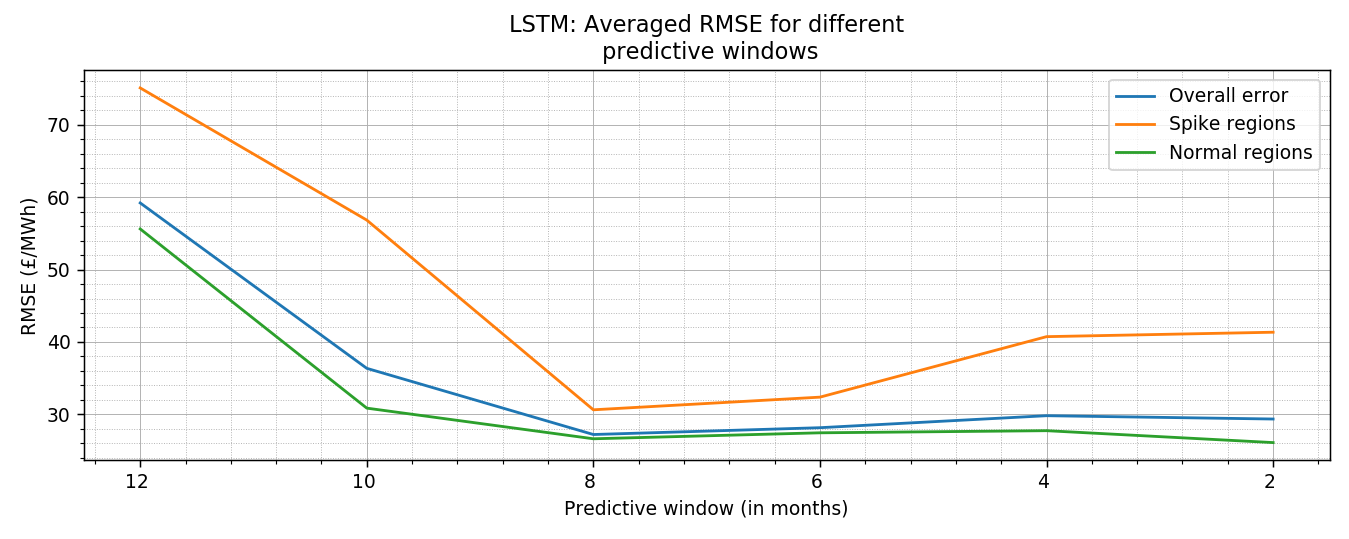

<IPython.core.display.Javascript object>


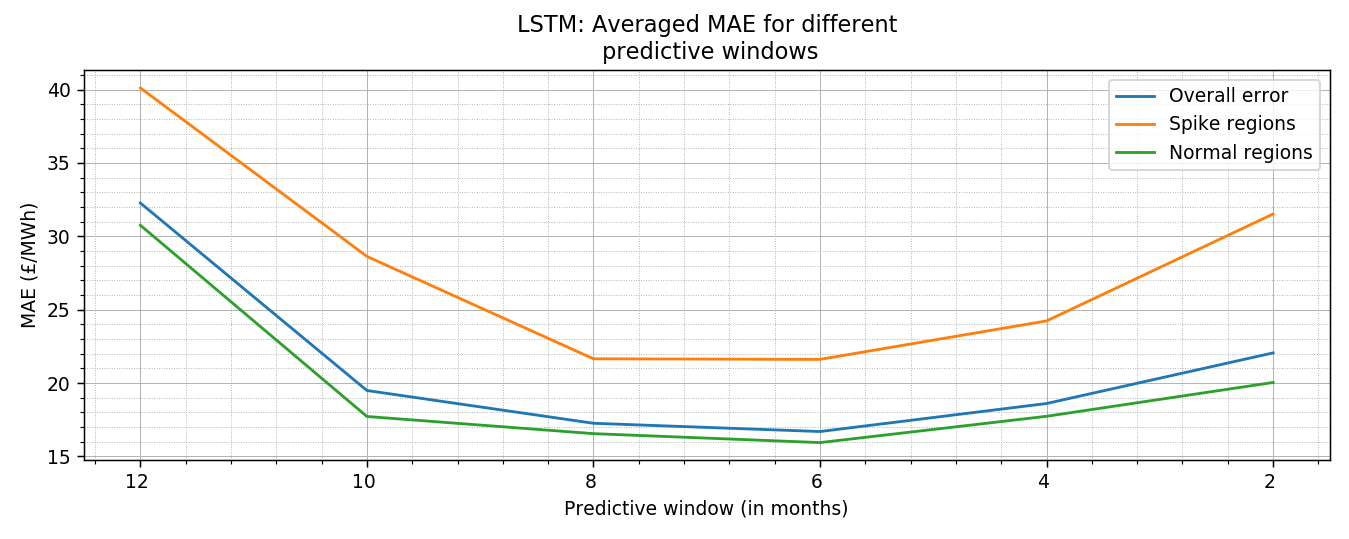

In [30]:
%matplotlib notebook

dates_labels = ['12 ',
                '10 ',
                '8 ',
                '6 ',
                '4 ',
                '2 ']

plt.figure(figsize=(10,4))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('LSTM: Averaged RMSE for different\n predictive windows')
plt.plot(rmse_gen, label = 'Overall error')
plt.plot(rmse_spi, label = 'Spike regions')
plt.plot(rmse_nor, label = 'Normal regions')
plt.legend()
plt.ylabel('RMSE (£/MWh)')
plt.xlabel('Predictive window (in months)')
plt.xticks([0,1,2,3,4,5], dates_labels)
plt.tight_layout()
plt.savefig('RMSE_predictive_window.png')

plt.figure(figsize=(10,4))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('LSTM: Averaged MAE for different\n predictive windows')
plt.plot(mae_gen, label = 'Overall error')
plt.plot(mae_spi, label = 'Spike regions')
plt.plot(mae_nor, label = 'Normal regions')
plt.legend()
plt.ylabel('MAE (£/MWh)')
plt.xlabel('Predictive window (in months)')
plt.xticks([0,1,2,3,4,5], dates_labels)
plt.tight_layout()
plt.savefig('MAE_predictive_window.png')